In [1]:
import numpy
import random
import copy 

In [6]:

colors = [
    (0, 0, 0),
    (120, 37, 179),
    (100, 179, 179),
    (80, 34, 22),
    (80, 134, 22),
    (180, 34, 22),
    (180, 34, 122),
]


class Figure:
    x = 0
    y = 0

    figures = [
        [[1, 5, 9, 13], [4, 5, 6, 7]],
        [[4, 5, 9, 10], [2, 6, 5, 9]],
        [[6, 7, 9, 10], [1, 5, 6, 10]],
        [[1, 2, 5, 9], [0, 4, 5, 6], [1, 5, 9, 8], [4, 5, 6, 10]],
        [[1, 2, 6, 10], [5, 6, 7, 9], [2, 6, 10, 11], [3, 5, 6, 7]],
        [[1, 4, 5, 6], [1, 4, 5, 9], [4, 5, 6, 9], [1, 5, 6, 9]],
        [[1, 2, 5, 6]],
    ]

    def __init__(self, x, y, type, color): #type : integer 0<7 #color : integer 0<7
        self.x = x
        self.y = y
        self.type = type #introduire random dans la classe Tetris 
        self.color = color #introduire random dans la classe Tetris 
        self.rotation = 0

    def image(self):
        return self.figures[self.type][self.rotation]

    def rotate(self,k):
        self.rotation = (self.rotation + k) % len(self.figures[self.type])



In [7]:
class Tetris:
    def __init__(self, height, width):
        self.score = 0
        self.state = "start" #tell us if we are still playing or not
        self.field = []
        self.height = 0
        self.width = 0
        self.x = 100
        self.y = 60
        self.figure = None
    
        self.height = height
        self.width = width
        self.field = []
        self.score = 0
        self.state = "start"

        for i in range(height): # create a field with the size height x width 
            new_line = []

            for j in range(width):
                new_line.append(0)
                
            self.field.append(new_line)

    def new_figure(self,type,x,y):
        self.figure = Figure(x, y,type,color=2) #type et color doivent être randomisés

    def intersects(self): #check if the currently flying figure intersecting with something fixed on the field. 
        intersection = False
        for i in range(4):
            for j in range(4):
                if i * 4 + j in self.figure.image():
                    if i + self.figure.y > self.height - 1 or \
                            j + self.figure.x > self.width - 1 or \
                            j + self.figure.x < 0 or \
                            self.field[i + self.figure.y][j + self.figure.x] > 0:
                        intersection = True
        return intersection



    def break_lines(self): #checking an detroying full lines
        lines = 0
        for i in range(1, self.height):
            zeros = 0
            for j in range(self.width):
                if self.field[i][j] == 0:
                    zeros += 1
            if zeros == 0:
                lines += 1
                for i1 in range(i, 1, -1):
                    for j in range(self.width):
                        self.field[i1][j] = self.field[i1 - 1][j]
        self.score += lines ** 2

    def go_space(self):
        while not self.intersects():
            self.figure.y += 1
        self.figure.y -= 1
        self.freeze()

    def freeze(self): #If it moves down and intersects, then this means we have reached the bottom, so we need to “freeze” the figure on our field:
        for i in range(4):
            for j in range(4):
                if i * 4 + j in self.figure.image():
                    self.field[i + self.figure.y][j + self.figure.x] = self.figure.color
        self.break_lines()

    def go_side(self, dx):
        old_x = self.figure.x
        self.figure.x += dx
        if self.intersects():
            self.figure.x = old_x

    def rotate(self,k):
        old_rotation = self.figure.rotation
        self.figure.rotate(k)
        if self.intersects():
            self.figure.rotation = old_rotation


In [8]:
#21 features 
def column_height(field): #from top to bottom
    h=[]
    for j in range(10):
        column=[field[i][j] for i in range(20)] 
        height=0

        while height<20 and column[height]==0 :
            height+=1

        h.append(20-height)

    return(h)


def maximum_height(field):
    return(max(column_height(field)))


def column_difference(field):# absolute difference between adjacent columns
    df=[]
    h=column_height(field)

    for j in range(9):
        df.append(abs(h[j+1]-h[j]))
    
    return(df)

def holes(field):
    L=0
    h=column_height(field)

    for j in range(10):
        for i in range(20-h[j],20):
            if field[i][j]==0:
                L+=1
    
    return(L)


In [9]:
def evaluate(W, field): 
    #W=[w1, ..., w21] vector of parameters to tune 

    h=column_height(field)
    dh=column_difference(field)
    L=holes(field)
    H=maximum_height(field)
    
    S1,S2,S3,S4=0,0,0,0

    for k in range (len(h)):
        S1+=h[k]*W[k]
    
    for k in range (len(dh)):
        S2+=dh[k]*W[10+k]

    S3=W[19]*L

    S4=W[20]*H

    return(S1+S2+S3+S4)

In [10]:

def evaluate_best_move(W,field,type):
    L=[]
    score=[]
    for col in range (-5,7):
        for k in range (4):
            game_copy=Tetris(20,10)
            
            game_copy.field=copy.deepcopy(field)

            game_copy.new_figure(type,3,0)
            
            game_copy.go_side(col)
            game_copy.rotate(k) #test intersect deja fait dans la methode rotate
            game_copy.go_space()
            score.append(evaluate(W,game_copy.field))
            L.append([col,k])
    
    best_move=score.index(min(score))
    return(L[best_move])

    
    

In [11]:
def simulation(W):
    # Initialize the game engine
    pygame.init()

    # Define some colors
    BLACK = (0, 0, 0)
    WHITE = (255, 255, 255)
    GRAY = (128, 128, 128)

    size = (400, 500)
    screen = pygame.display.set_mode(size)

    pygame.display.set_caption("Tetris")

    # Loop until the user clicks the close button.
    done = False
    clock = pygame.time.Clock()
    fps = 25
    game = Tetris(20, 10)
    counter = 0

    while not done:
        if game.figure is None:
            fig=random.randint(0,6)
            game.new_figure(fig,3,0) 
        counter += 1

        if counter > 100000:
            counter = 0
            
        game.state = "start"

        while game.state != "gameover":
            fig=random.randint(0,6)
            game.new_figure(fig,3,0)
            if game.intersects()==True:
                game.state="gameover "
            counter += 1
                #  if counter > 100000:
                #     counter = 0
            col, rot = evaluate_best_move(W,game.field,fig)
            
            game.rotate(rot)
            
            game.go_side(col)
            game.go_space()
                    
            
       # if event.type == pygame.KEYUP:
       #         if event.key == pygame.K_DOWN:
       #             pressing_down = False

        screen.fill(WHITE)

        for i in range(game.height):
            for j in range(game.width):
                pygame.draw.rect(screen, GRAY, [game.x + game.zoom * j, game.y + game.zoom * i, game.zoom, game.zoom], 1)
                if game.field[i][j] > 0:
                    pygame.draw.rect(screen, colors[game.field[i][j]],
                                     [game.x + game.zoom * j + 1, game.y + game.zoom * i + 1, game.zoom - 2, game.zoom - 1])

        if game.figure is not None:
            for i in range(4):
                for j in range(4):
                    p = i * 4 + j
                    if p in game.figure.image():
                        pygame.draw.rect(screen, colors[game.figure.color],
                                         [game.x + game.zoom * (j + game.figure.x) + 1,
                                          game.y + game.zoom * (i + game.figure.y) + 1,
                                          game.zoom - 2, game.zoom - 2])

        font = pygame.font.SysFont('Calibri', 25, True, False)
        font1 = pygame.font.SysFont('Calibri', 65, True, False)
        text = font.render("Score: " + str(game.score), True, BLACK)
        text_game_over = font1.render("Game Over", True, (255, 125, 0))
        text_game_over1 = font1.render("Press ESC", True, (255, 215, 0))

        screen.blit(text, [0, 0])
        if game.state == "gameover":
            screen.blit(text_game_over, [20, 200])
            screen.blit(text_game_over1, [25, 265])

        pygame.display.flip()
        clock.tick(fps)

        print()

    pygame.quit()

In [12]:
def simulation_without_graphic(W):


    game = Tetris(20, 10)
    counter = 0

    while game.state!="gameover":

        fig=random.randint(0,6)
        game.new_figure(fig,3,0)
        if game.intersects():
            game.state="gameover"

        col, rot = evaluate_best_move(W,game.field,fig)
        
        game.rotate(rot)
        game.go_side(col)
        game.go_space()

            
    return(game.score)



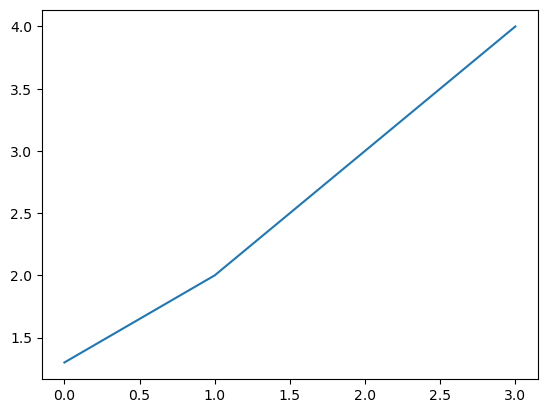

In [5]:
import matplotlib.pyplot as plt
plt.plot([1.3,2,3,4])